In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s6e1/sample_submission.csv
/kaggle/input/playground-series-s6e1/train.csv
/kaggle/input/playground-series-s6e1/test.csv


>This is Supervised,and regression problem
>
>matrics to use RMSE
>
>Traget Col is exam_score
>
>Shape 630000x13
>
>Dataleakage --> Id

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


In [3]:
# Load dataset 
df = pd.read_csv('/kaggle/input/playground-series-s6e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s6e1/test.csv')

In [4]:
df.shape

(630000, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB


> There is no null value in dataset 

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.describe()

,id,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987261,7.072758,62.506672
std,181865.479132,2.260238,2.359880,17.430098,1.744811,18.916884
min,0.000000,17.000000,0.080000,40.600000,4.100000,19.599000
25%,157499.750000,19.000000,1.970000,57.000000,5.600000,48.800000
50%,314999.500000,21.000000,4.000000,72.600000,7.100000,62.600000
75%,472499.250000,23.000000,6.050000,87.200000,8.600000,76.300000
max,629999.000000,24.000000,7.910000,99.400000,9.900000,100.000000


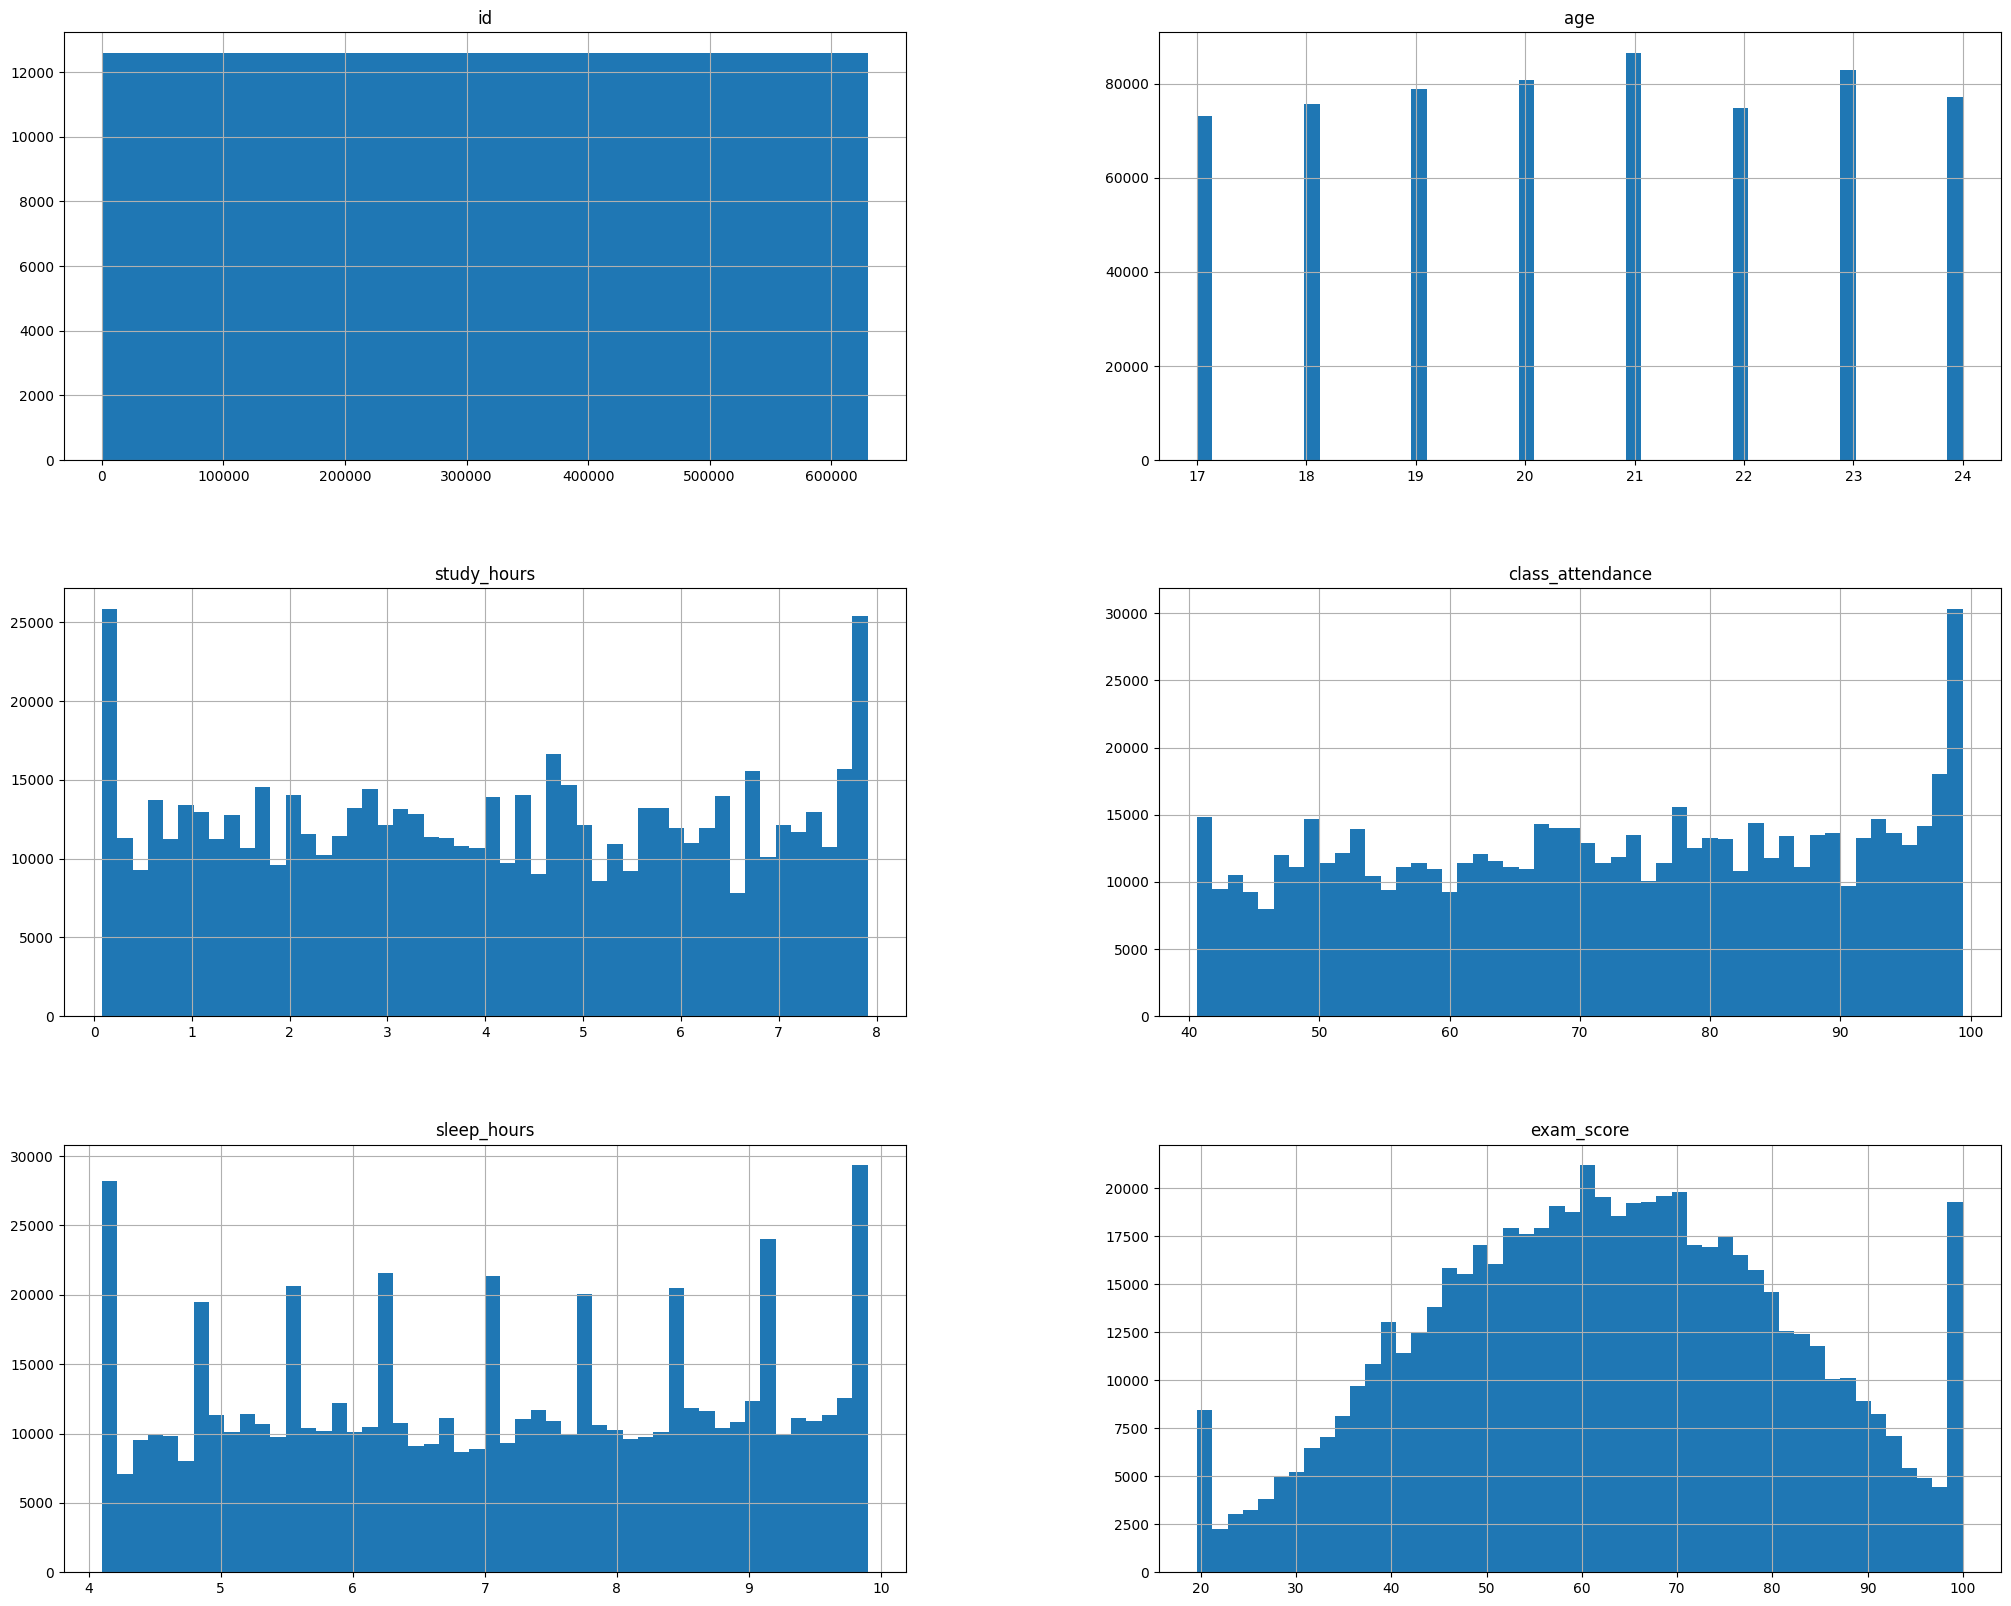

In [8]:
# plot histogram of numeric cols
df.hist(bins=50,figsize=(25,20))
plt.show()

In [9]:
df['high_att+study']= ((df['class_attendance']>=90) &(df['study_hours']>=6)).astype(int)
df['ideal_sleep'] = ((df['sleep_hours']>=7) & (df['sleep_hours']<=9)).astype(int)
df['ideal_study'] = (df['study_hours']>=7).astype(int)

In [10]:
# eps = 1e-5
# df['study_hours_over_sleep'] = df['study_hours'] / (df['sleep_hours'] + eps)
# df['study_hours_over_att'] = df['study_hours'] / (df['class_attendance'] + eps)
# #df['attendance_over_sleep'] = df['class_attendance'] / (df['sleep_hours'] + eps)
# df['attendance_over_study_hour'] = df['class_attendance'] / (df['study_hours'] + eps)
# # df['extra_hours']= 24 - (df['study_hours']+df['sleep_hours'])
# df['age_with_study_hours'] = df['age']*df['study_hours']
# df['age_with_sleep_hours'] = df['age']*df['sleep_hours']
# df['age_with_attendance'] = df['age']*df['class_attendance']

In [11]:
# sleep_quality_mean = df.groupby('sleep_quality')['study_hours'].mean()
# df['sleep_quality_avg_study_hours'] = df['sleep_quality'].map(sleep_quality_mean)

# att_mean = df.groupby('age').size()
# df['sleep_quality_avg_att'] = df['age'].map(att_mean)

# facility_rating_mean = df.groupby('facility_rating')['study_hours'].mean()
# df['facility_rating_avg_study_hours'] = df['facility_rating'].map(facility_rating_mean)

In [12]:
X = df.drop(columns=['id','exam_score'])
y = df['exam_score']

In [13]:
# split data
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2,random_state=42)

In [14]:
X_train.shape

(504000, 14)

In [15]:
X_val.shape

(126000, 14)

In [16]:
# seperate numerical and categorical columns
num_col = pd.DataFrame(X_train.select_dtypes(include=['int64','float64']))
cat_col = X_train.select_dtypes(include=['object']).columns

In [17]:
# value_count for categorical data
for col in cat_col:
    print(df[col].value_counts())

gender
other     211097
male      210593
female    208310
Name: count, dtype: int64
course
b.tech     131236
b.sc       111554
b.com      110932
bca         88721
bba         75644
ba          61989
diploma     49924
Name: count, dtype: int64
internet_access
yes    579423
no      50577
Name: count, dtype: int64
sleep_quality
poor       213675
good       213089
average    203236
Name: count, dtype: int64
study_method
coaching         131697
self-study       131131
mixed            123086
group study      123009
online videos    121077
Name: count, dtype: int64
facility_rating
medium    214082
low       212378
high      203540
Name: count, dtype: int64
exam_difficulty
moderate    353982
easy        176540
hard         99478
Name: count, dtype: int64


In [18]:
num_col.corrwith(y_train)

age                 0.010552
study_hours         0.762415
class_attendance    0.362447
sleep_hours         0.167702
high_att+study      0.326459
ideal_sleep         0.063108
ideal_study         0.448294
dtype: float64

In [19]:
# import seaborn as sns 
# sns.pairplot(num_col)
# plt.show()

In [20]:
# for col in num_col:
#     plt.figure(figsize=(30,10))
#     sns.boxplot(x=num_col[col],y=y_train)
#     plt.show

In [21]:
ordinal_col = ['internet_access','sleep_quality','facility_rating','exam_difficulty']

normina_col = [col for col in cat_col if col not in ordinal_col ]

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

class CappingTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer for capping outliers in a normal distribution 
    based on standard deviations within a scikit-learn pipeline.
    
    Attributes:
        std_devs (float): The number of standard deviations to use for bounds.
        upper_bounds_ (dict): Stored upper bounds for each feature during fit.
        lower_bounds_ (dict): Stored lower bounds for each feature during fit.
    """
    def __init__(self, std_devs=3.0):
        self.std_devs = std_devs
        self.upper_bounds_ = {}
        self.lower_bounds_ = {}

    def fit(self, X, y=None):
        """Calculates the capping bounds based on the input data."""
        # Check if X is a pandas DataFrame and convert to numpy array if not for consistency
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
            
        for col in X.columns:
            mean = X[col].mean()
            std = X[col].std()
            self.upper_bounds_[col] = mean + (self.std_devs * std)
            self.lower_bounds_[col] = mean - (self.std_devs * std)
            
        return self

    def transform(self, X):
        """Applies the capping bounds to the input data."""
        # Ensure transformation data matches the structure of fitting data
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
            
        X_capped = X.copy()
        for col in X_capped.columns:
            # Clip values: values above upper bound become the upper bound, 
            # and values below the lower bound become the lower bound.
            X_capped[col] = np.clip(X_capped[col], 
                                    self.lower_bounds_[col], 
                                    self.upper_bounds_[col])
            
        return X_capped


In [23]:
outlier =  ['study_hours','class_attendance','ideal_study','high_att+study']

In [24]:
num_pipe = Pipeline([
    ('imputer',SimpleImputer(strategy='mean')),
    ('scale',StandardScaler())
])

ord_pipe =Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OrdinalEncoder(
        categories=[
         
                    ['yes','no'],
                    ['good','average','poor'],
                    ['high','medium','low'],
                    ['easy','moderate','hard']
         
        ]
    ))
])

nor_pipe = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(handle_unknown='ignore'))
])

out_pipe = Pipeline([
     ('capper', CappingTransformer(std_devs=3.0)),
])

In [25]:
num_col = X_train.select_dtypes(include=['int64','float64']).columns

In [26]:
preprocessor = ColumnTransformer([
    ('out', out_pipe, outlier),
    ('num', num_pipe, num_col),
    ('ord', ord_pipe, ordinal_col),
    ('nom', nor_pipe, normina_col)
])

In [27]:
N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)


In [28]:
oof_lgb = np.zeros(len(X_train))
oof_cat = np.zeros(len(X_train))

test_pred_lgb = np.zeros(len(X_val))
test_pred_cat = np.zeros(len(X_val))

In [29]:
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

In [30]:
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\nFold {fold+1}")

    X_tr, X_vall = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_vall = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    # ---------- LGBM ----------
    lgb_pipe = Pipeline([
        ('prep', preprocessor),
        ('model', LGBMRegressor(
            n_estimators=2500,
            learning_rate=0.057,
            max_depth=5,
            random_state=42,
            n_jobs=-1,
            verbosity=-1
        ))
    ])

    lgb_pipe.fit(X_tr, y_tr)

    oof_lgb[val_idx] = lgb_pipe.predict(X_vall)
    test_pred_lgb += lgb_pipe.predict(X_val) / N_FOLDS

    # ---------- CatBoost ----------
    cat_model = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.05,
        depth=6,
        loss_function='RMSE',
        random_seed=42,
        verbose=0
    )

    cat_model.fit(X_tr, y_tr,cat_features=cat_cols)

    oof_cat[val_idx] = cat_model.predict(X_vall)
    test_pred_cat += cat_model.predict(X_val) / N_FOLDS



Fold 1


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Fold 2


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Fold 3


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Fold 4


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Fold 5


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [31]:
rmse_lgb = np.sqrt(mean_squared_error(y_train, oof_lgb))
rmse_cat = np.sqrt(mean_squared_error(y_train, oof_cat))

print("LGBM CV RMSE:", rmse_lgb)
print("CatBoost CV RMSE:", rmse_cat)

LGBM CV RMSE: 8.742459822790696
CatBoost CV RMSE: 8.761726940221488


In [32]:
w=0.621
oof_ens = w* oof_lgb + (1-w) * oof_cat
rmse_ens = np.sqrt(mean_squared_error(y_train, oof_ens))

print("Ensemble CV RMSE:", rmse_ens)

Ensemble CV RMSE: 8.730365270273081


In [33]:
# residuals = y_train- oof_ens
# error_df = y_train.copy()
# error_df['residual'] = residuals
# error_df['abs_error'] = abs(residuals)

In [34]:
# error_df['abs_error'].sort_values(ascending=False).head(20)

78392     47.411176
428160    46.837003
613957    45.201020
47775     43.967701
526766    42.417041
304834    42.183831
288715    41.788665
31253     41.421904
93901     41.371901
51537     41.303819
538911    41.251852
547691    41.249587
258607    40.713526
590151    40.674362
505456    40.549849
366570    39.981701
431217    39.595474
236686    39.542694
340684    39.443989
51409     39.204665
Name: exam_score, dtype: float64

In [35]:
# y_train.loc[[560300,125329,428604]]

560300    100.0
125329    100.0
428604    100.0
Name: exam_score, dtype: float64

In [36]:
# lgb_test_pred = lgb_pipe.predict(test)

In [37]:

# from catboost import Pool

# cat_cols = test.select_dtypes(include='object').columns.tolist()

# test_pool = Pool(
#     data=test,
#     cat_features=cat_cols
# )

# cat_test_pred = cat_model.predict(test_pool)

In [38]:
# final_test_pred = 0.6 * lgb_test_pred + 0.4 * cat_test_pred

In [39]:
# eps = 1e-5

# test['study_hours_over_sleep'] = test['study_hours'] / (test['sleep_hours'] + eps)
# test['study_hours_over_att'] = test['study_hours'] / (test['class_attendance'] + eps)
# # test['attendance_over_sleep'] = test['class_attendance'] / (test['sleep_hours'] + eps)
# test['attendance_over_study_hour'] = test['class_attendance'] / (test['study_hours'] + eps)
# # test['extra_hours'] = 24 - (test['study_hours'] + test['sleep_hours'])
# test['age_with_study_hours'] = test['age'] * test['study_hours']
# test['age_with_sleep_hours'] = test['age'] * test['sleep_hours']
# test['age_with_attendance'] = test['age'] * test['class_attendance']


In [40]:
# sleep_quality_mean = test.groupby('sleep_quality')['study_hours'].mean()
# test['sleep_quality_avg_study_hours'] = test['sleep_quality'].map(sleep_quality_mean)

# att_mean = test.groupby('age').size()
# test['sleep_quality_avg_att'] = test['age'].map(att_mean)

# facility_rating_mean = test.groupby('facility_rating')['study_hours'].mean()
# test['facility_rating_avg_study_hours'] = test['facility_rating'].map(facility_rating_mean)


In [41]:

# submission = pd.DataFrame({
#     'id': test['id'],
#     'exam_score':final_test_pred
# })
# submission.to_csv('submission.csv', index=False)